In [39]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from glob import glob
from PIL import Image
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.utils import to_categorical, plot_model
from keras.layers import Input
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [40]:
skinDf=pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
skinDf.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [41]:
labelEncoder = LabelEncoder()
labelEncoder.fit(skinDf['dx'])
skinDf['label']=labelEncoder.transform(skinDf['dx'])

dfs_by_label_resampled = {}
n_samples = 800

for label in range(7):  
    df_label_resampled = resample(skinDf[skinDf['label'] == label], n_samples=n_samples, replace=True, random_state=42)
    
    # Append the resampled DataFrame to the dictionary
    dfs_by_label_resampled[label] = df_label_resampled

balanced_df = pd.concat(dfs_by_label_resampled.values())

# Shuffle the rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df['label'].value_counts()

imgPath={os.path.splitext(os.path.basename(x))[0]: x
                            for x in glob(os.path.join('/kaggle/input/skin-cancer-mnist-ham10000/','*','*.jpg'))}    

size = (76, 76)

balanced_df['image'] = balanced_df['image_id'].map(imgPath.get).map(lambda x: np.asarray(Image.open(x).resize(size)))

In [42]:
x=np.asarray(balanced_df['image'].to_list())

y=balanced_df['label']
y=to_categorical(y, num_classes=7)

x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42, shuffle=True)  # 0.25 x 0.8 = 0.2

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")

x_train shape: (3360, 76, 76, 3) - y_train shape: (3360, 7)
x_test shape: (1120, 76, 76, 3) - y_test shape: (1120, 7)
x_val shape: (1120, 76, 76, 3) - y_val shape: (1120, 7)


In [43]:
train_y = y_train
test_y = y_test
val_y = y_val
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)
y_val = np.argmax(y_val, axis=1)

# Ensure data type is float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')

# Normalize the pixel values to the range [0, 1]
x_train /= 255.0
x_test /= 255.0
x_val /= 255.0

# resize images to 96x96
x_train = np.array([resize(image, (96, 96)) for image in x_train])
x_test = np.array([resize(image, (96, 96)) for image in x_test])
x_val = np.array([resize(image, (96, 96)) for image in x_val])

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")

x_train shape: (3360, 96, 96, 3) - y_train shape: (3360,)
x_test shape: (1120, 96, 96, 3) - y_test shape: (1120,)
x_val shape: (1120, 96, 96, 3) - y_val shape: (1120,)


In [44]:
num_classes=7
batch_size = 32
classes = ['aklec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
input_shape = (96, 96, 3)
input_layer = Input(shape=input_shape)

In [45]:
def plot_images(df, indices, width=200, height=200):
    num_images = len(indices)
    size = (128, 128)
    images = [Image.fromarray(df['image'].iloc[i]).resize(size) for i in indices]
    images = [np.array(img) for img in images]

    fig = make_subplots(rows=1, cols=num_images, subplot_titles=[f"{classes[df['label'].iloc[i]]}" for i in indices])

    for i, img in enumerate(images, start=1):
        fig.add_trace(go.Image(z=img), row=1, col=i)

    fig.update_layout(
        width=width*num_images,  # Adjust the total width of the plot
        height=height,
        margin=dict(l=10, r=10, t=45, b=20),
    )

    fig.show()

In [46]:
plot_images(balanced_df, [1, 2, 3, 8])
plot_images(balanced_df, [9, 17, 29])

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # randomly rotate images by 20 degrees
    width_shift_range=0.1,  # randomly shift images horizontally by 10%
    height_shift_range=0.1,  # randomly shift images vertically by 10%
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False,  # do not flip images vertically
    zoom_range=0.1  # randomly zoom into images by 20%
)

# Fit the data generator on the training data
datagen.fit(x_train)

# Generate augmented data
augmented_data = datagen.flow(x_train, y_train, batch_size=batch_size)

In [48]:
from keras.applications.xception import Xception

xception_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in xception_model.layers:
    layer.trainable = True

x = xception_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_xception_model = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_xception = Model(inputs=input_layer, outputs=output_xception_model)

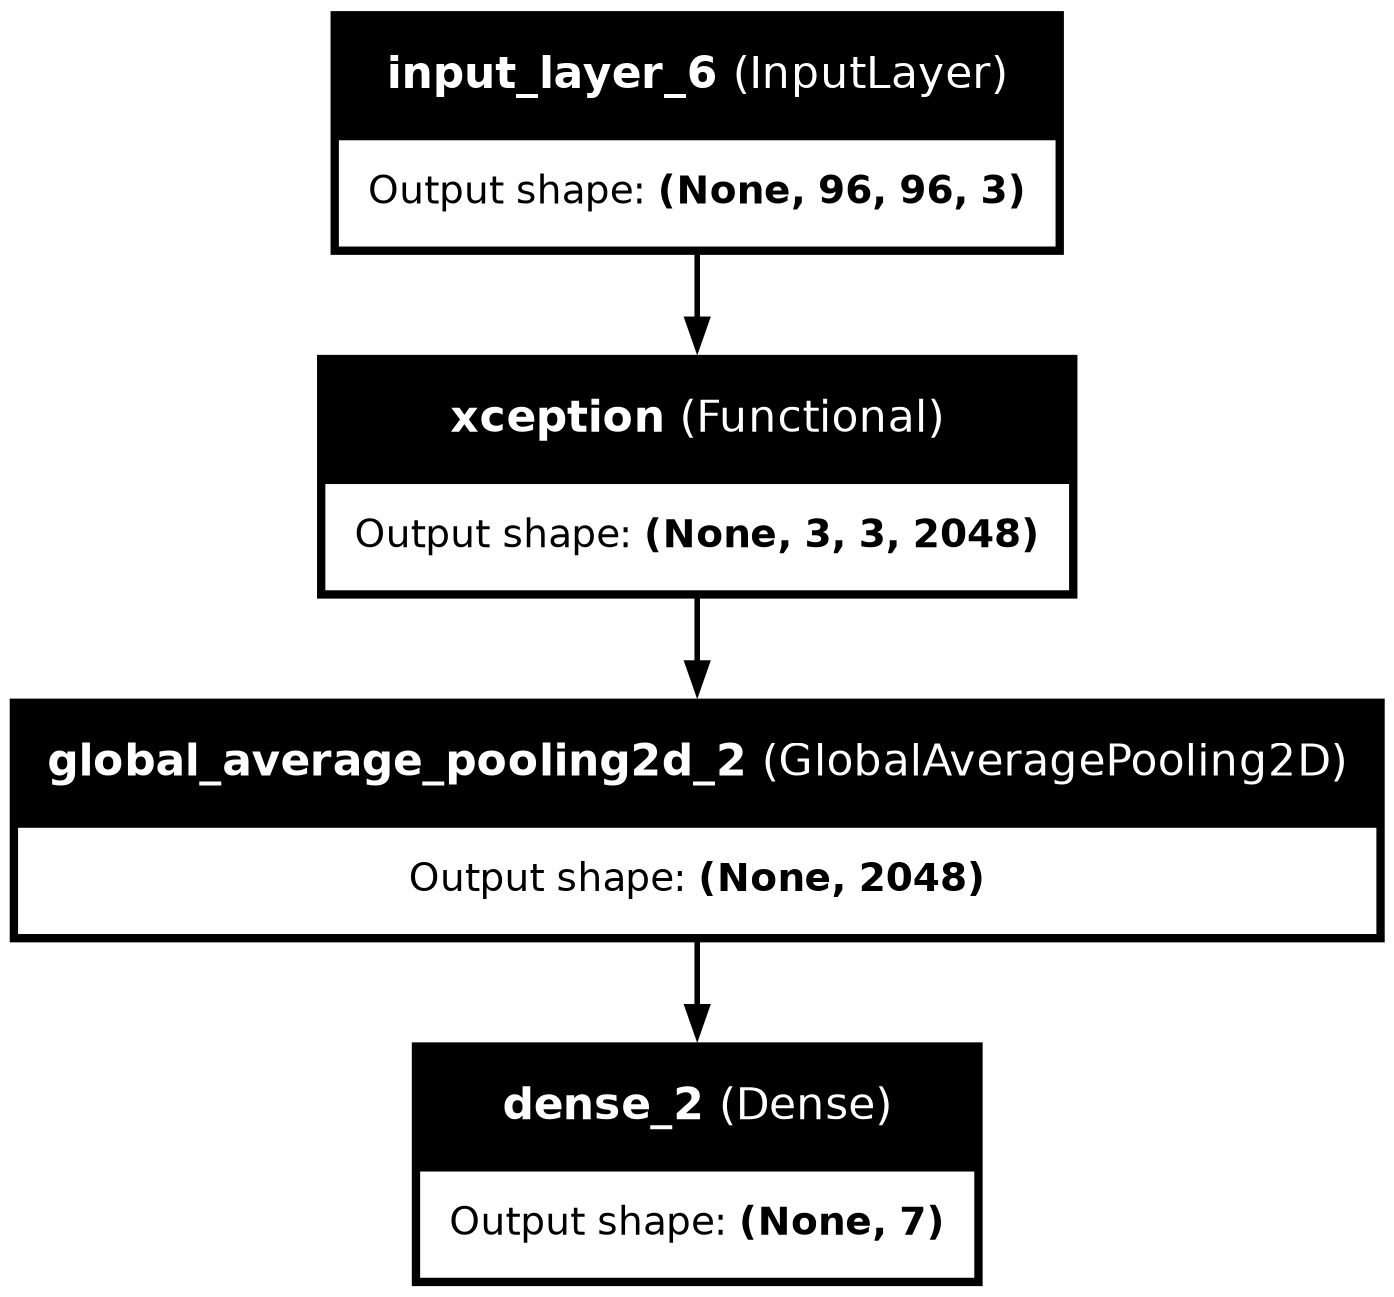

In [49]:
image_path = 'model_architecture_xception_v2.png'
plot_model(model_xception, to_file=image_path, show_shapes=True, show_layer_names=True)

In [50]:
# Compile the model
model_xception.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

# Train the model
history_xception = model_xception.fit(
    augmented_data,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate the model
print("\nEvaluate in test dataset:")
model_xception.evaluate(x_test, y_test)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



  1/105 ━━━━━━━━━━━━━━━━━━━━ 1:06:13 38s/step - accuracy: 0.0938 - loss: 2.0232

W0000 00:00:1712075713.494229      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4547 - loss: 1.4670

W0000 00:00:1712075726.746303      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/105 ━━━━━━━━━━━━━━━━━━━━ 53s 138ms/step - accuracy: 0.4557 - loss: 1.4646 - val_accuracy: 0.5232 - val_loss: 2.2631 - learning_rate: 0.0010
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.7037 - loss: 0.8483 - val_accuracy: 0.6884 - val_loss: 1.0460 - learning_rate: 0.0010
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.7563 - loss: 0.6703 - val_accuracy: 0.7027 - val_loss: 0.8303 - learning_rate: 0.0010
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.7874 - loss: 0.5907 - val_accuracy: 0.7134 - val_loss: 0.9710 - learning_rate: 0.0010
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.8383 - loss: 0.4731 - val_accuracy: 0.7348 - val_loss: 0.8885 - learning_rate: 0.0010
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.8386 - loss: 0.4581 - val_accuracy: 0.7018 - val_loss: 0.9667 - learning_rate: 0.0010
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.8643 - loss:

[0.3691644072532654, 0.8866071701049805]

In [51]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

inception_resnet_v2_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in inception_resnet_v2_model.layers:
    layer.trainable = True

x = inception_resnet_v2_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_inception_resnet_v2 = tf.keras.layers.Dense(7, activation='softmax')(x)

model_inception_resnet_v2 = Model(inputs=input_layer, outputs=output_inception_resnet_v2)

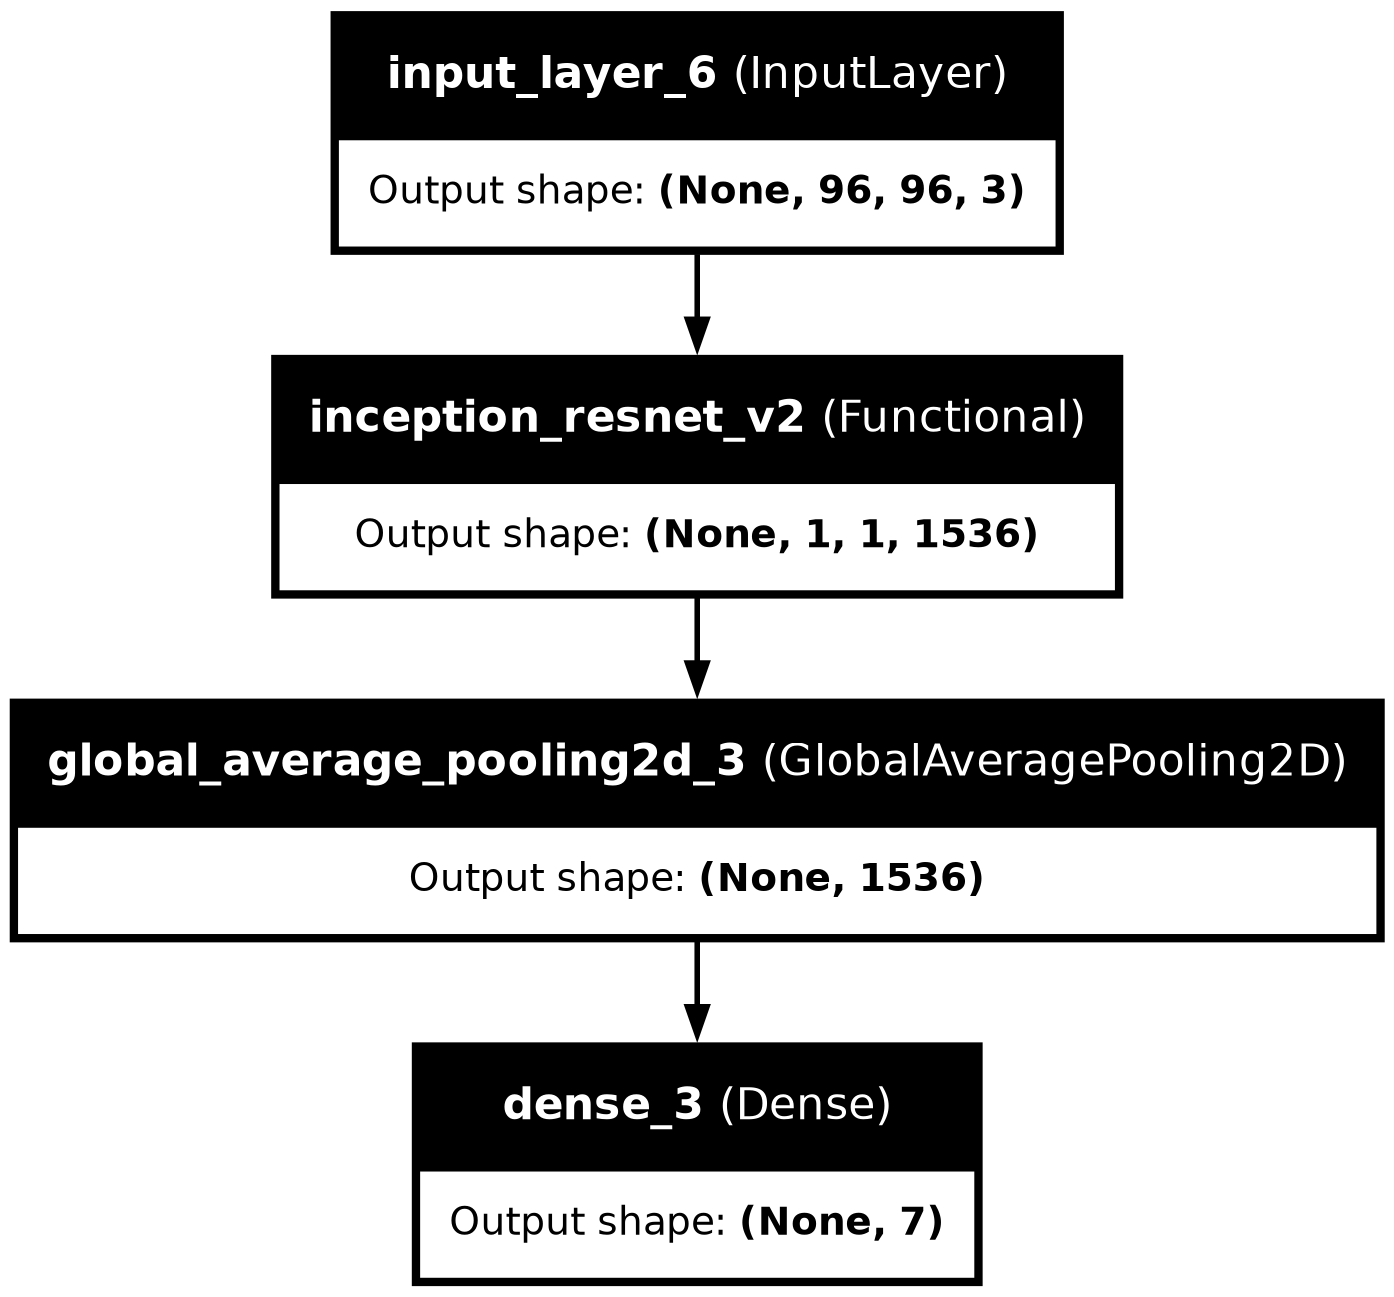

In [52]:
image_path = 'model_architecture_inception_resnet_v2.png'
plot_model(model_inception_resnet_v2, to_file=image_path, show_shapes=True, show_layer_names=True)

In [53]:
# Compile the model
model_inception_resnet_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

# Train the model
history_inception_resnet_v2 = model_inception_resnet_v2.fit(
    augmented_data,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate the model
print("\nEvaluate in test dataset:")
model_inception_resnet_v2.evaluate(x_test, y_test)

Epoch 1/30
  1/105 ━━━━━━━━━━━━━━━━━━━━ 5:11:59 180s/step - accuracy: 0.1250 - loss: 2.2338

W0000 00:00:1712076244.721436      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.4223 - loss: 1.9533

W0000 00:00:1712076269.792407      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/105 ━━━━━━━━━━━━━━━━━━━━ 207s 259ms/step - accuracy: 0.4231 - loss: 1.9492 - val_accuracy: 0.4429 - val_loss: 2.8421 - learning_rate: 0.0010
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.6432 - loss: 1.0440 - val_accuracy: 0.3964 - val_loss: 58.3434 - learning_rate: 0.0010
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.7063 - loss: 1.0167 - val_accuracy: 0.6268 - val_loss: 79.5658 - learning_rate: 0.0010
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.7627 - loss: 0.7282 - val_accuracy: 0.5750 - val_loss: 4.2577 - learning_rate: 0.0010
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.7739 - loss: 0.6720 - val_accuracy: 0.4545 - val_loss: 3.5609 - learning_rate: 0.0010
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.7963 - loss: 0.5758 - val_accuracy: 0.7625 - val_loss: 0.6337 - learning_rate: 0.0010
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.8252 - lo

[0.5594050288200378, 0.8205357193946838]

In [69]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet_v2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in mobilenet_v2_model.layers:
    layer.trainable = True

x = mobilenet_v2_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output_mobilenet_v2_model = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_mobilenet_v2 = Model(inputs=input_layer, outputs=output_mobilenet_v2_model)

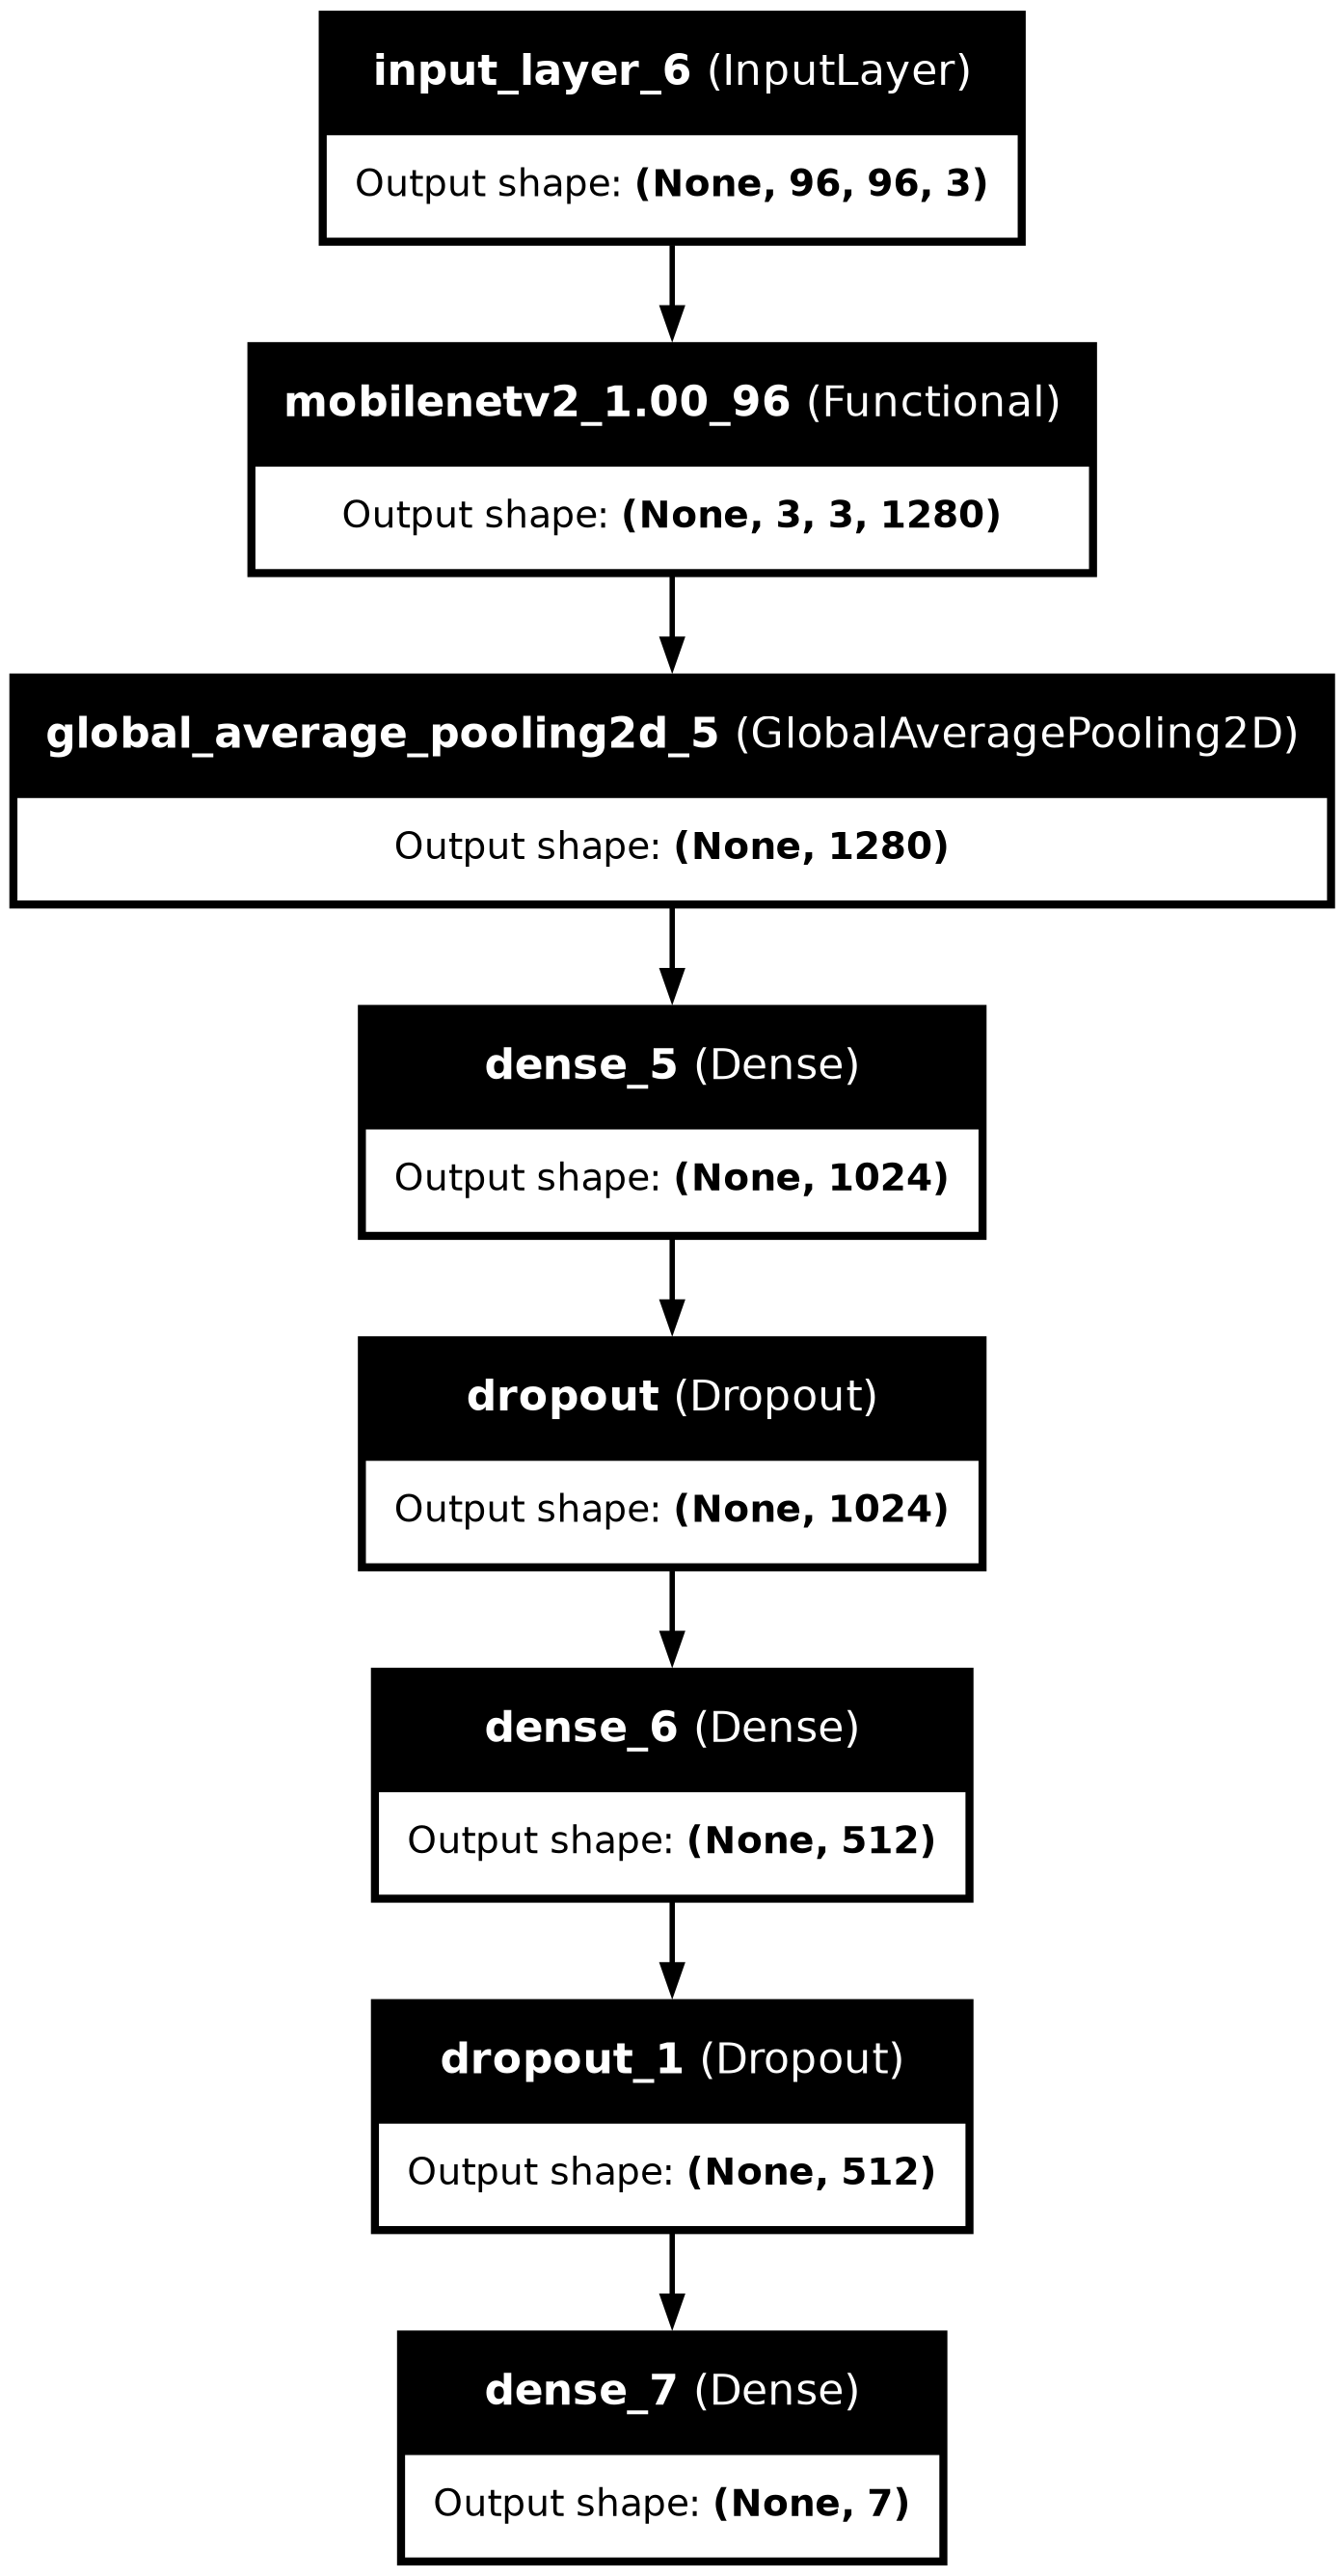

In [70]:
image_path = 'model_architecture_mobilenet_v2.png'
plot_model(model_mobilenet_v2, to_file=image_path, show_shapes=True, show_layer_names=True)

In [74]:
# Compile the model
model_mobilenet_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

# Train the model
history_mobilenet_v2 = model_mobilenet_v2.fit(
    augmented_data,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate the model
print("\nEvaluate in test dataset:")
model_mobilenet_v2.evaluate(x_test, y_test)

Epoch 1/50
  3/105 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8698 - loss: 0.4017    

W0000 00:00:1712077738.210874      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7683 - loss: 0.7370

W0000 00:00:1712077749.082544      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/105 ━━━━━━━━━━━━━━━━━━━━ 58s 109ms/step - accuracy: 0.7680 - loss: 0.7375 - val_accuracy: 0.5330 - val_loss: 2.6001 - learning_rate: 0.0010
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.7659 - loss: 0.7033 - val_accuracy: 0.1955 - val_loss: 10.0631 - learning_rate: 0.0010
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.7881 - loss: 0.6858 - val_accuracy: 0.2393 - val_loss: 8.2846 - learning_rate: 0.0010
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.8159 - loss: 0.5647 - val_accuracy: 0.1446 - val_loss: 23.2450 - learning_rate: 0.0010
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.8105 - loss: 0.5781 - val_accuracy: 0.4027 - val_loss: 3.9704 - learning_rate: 0.0010
Epoch 6/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8147 - loss: 0.5534
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.8146 - loss: 0.5538 - 

[0.481782466173172, 0.8839285969734192]

In [75]:
#Fuzzy Rank-based Ensemble:
def generateRank1(score,class_no):
  rank = np.zeros([class_no,1])
  scores = np.zeros([class_no,1])
  scores = score
  for i in range(class_no):
      rank[i] = 1 - np.exp(-((scores[i]-1)**2)/2.0)
  return rank

def generateRank2(score,class_no):
  rank = np.zeros([class_no,1])
  scores = np.zeros([class_no,1])
  scores = score
  for i in range(class_no):
      rank[i] = 1 - np.tanh(((scores[i]-1)**2)/2)
  return rank

def doFusion(res1, res2, res3, label, class_no):
    cnt = 0
    id = []
    for i in range(len(res1)):
        rank1 = generateRank1(res1[i], class_no) * generateRank2(res1[i], class_no)
        rank2 = generateRank1(res2[i], class_no) * generateRank2(res2[i], class_no)
        rank3 = generateRank1(res3[i], class_no) * generateRank2(res3[i], class_no)
        rankSum = rank1 + rank2 + rank3
        rankSum = np.array(rankSum)
        scoreSum = 1 - (res1[i] + res2[i] + res3[i]) / 3
        scoreSum = np.array(scoreSum)

        fusedScore = (rankSum.T) * scoreSum
        cls = np.argmin(rankSum)
        if cls<class_no and label[i][cls]== 1:  # Compare indices directly
            cnt += 1
        id.append(cls)
    print(cnt / len(res1))
    return id

In [76]:
pred_xception = model_xception.predict(x_test)
pred_inception_resnet_v2 = model_inception_resnet_v2.predict(x_test)
pred_mobilenet_v2 = model_mobilenet_v2.predict(x_test)
pred_ensembled = doFusion(pred_xception, pred_inception_resnet_v2,pred_mobilenet_v2, test_y, class_no=num_classes)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
19/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

W0000 00:00:1712078499.235193      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
0.9035714285714286


In [77]:
label_xception = np.argmax(pred_xception, axis=-1)
label_inception_resnet_v2 = np.argmax(pred_inception_resnet_v2, axis=-1)
label_mobilenet_v2 = np.argmax(pred_mobilenet_v2, axis=-1)

print('Xception base learner')
print(classification_report(y_test, label_xception, target_names=classes, digits=4))
print('InceptionResNetV2 base learner')
print(classification_report(y_test, label_inception_resnet_v2, target_names=classes, digits=4))
print('MobileNetV2 base learner')
print(classification_report(y_test, label_mobilenet_v2, target_names=classes, digits=4))
print('Ensembled')
print(classification_report(y_test, pred_ensembled, target_names=classes, digits=4))

Xception base learner
              precision    recall  f1-score   support

       aklec     0.9286    0.8966    0.9123       174
         bcc     0.9226    0.9118    0.9172       170
         bkl     0.8456    0.7770    0.8099       148
          df     0.9767    1.0000    0.9882       168
         mel     0.8056    0.7342    0.7682       158
          nv     0.7433    0.8797    0.8058       158
        vasc     0.9931    1.0000    0.9965       144

    accuracy                         0.8866      1120
   macro avg     0.8879    0.8856    0.8854      1120
weighted avg     0.8887    0.8866    0.8864      1120

InceptionResNetV2 base learner
              precision    recall  f1-score   support

       aklec     0.9426    0.6609    0.7770       174
         bcc     0.7817    0.9059    0.8392       170
         bkl     0.7075    0.7027    0.7051       148
          df     1.0000    0.9821    0.9910       168
         mel     0.6425    0.7848    0.7066       158
          nv     0.7727  

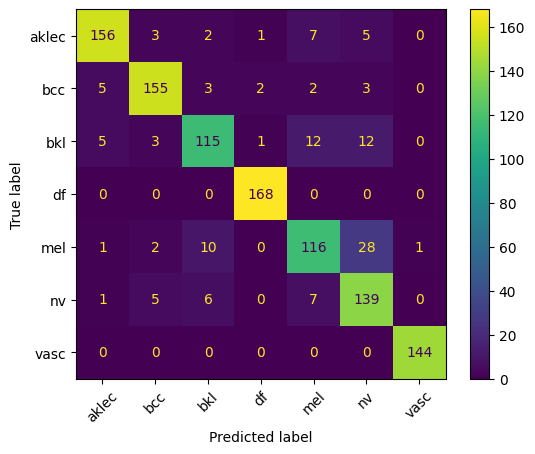

In [60]:
cm_xception = confusion_matrix(y_test, label_xception)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xception, display_labels=classes)
disp.plot(xticks_rotation=45)

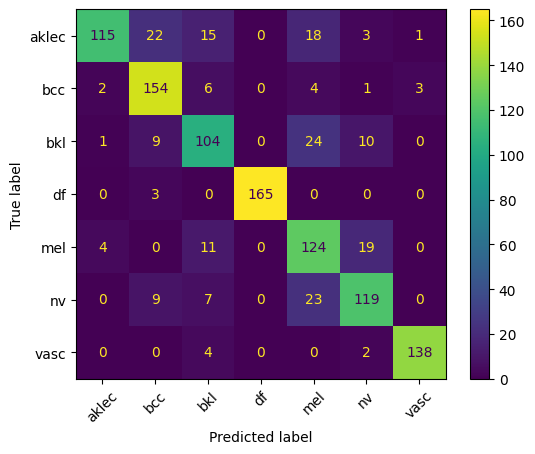

In [61]:
cm_inception_resnet_v2 = confusion_matrix(y_test, label_inception_resnet_v2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_inception_resnet_v2, display_labels=classes)
disp.plot(xticks_rotation=45)

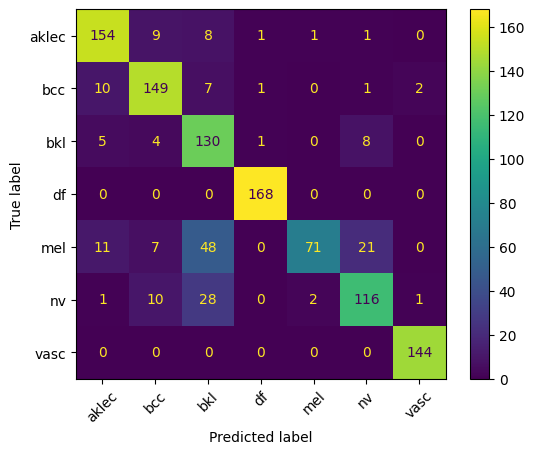

In [62]:
cm_mobilenet_v2 = confusion_matrix(y_test, label_mobilenet_v2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mobilenet_v2, display_labels=classes)
disp.plot(xticks_rotation=45)

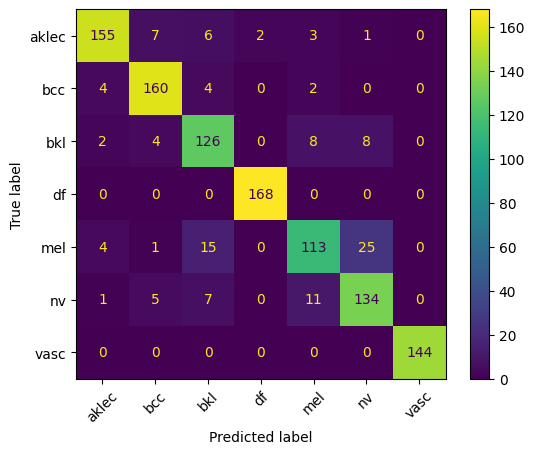

In [63]:
cm_ensembled = confusion_matrix(y_test, pred_ensembled)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensembled, display_labels=classes)
disp.plot(xticks_rotation=45)

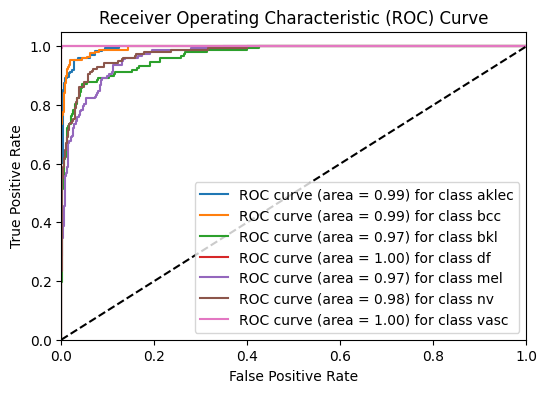

In [64]:
num_classes = 7

# Compute ROC curve and ROC area for each class
fpr_xception = dict()
tpr_xception = dict()
roc_auc_xception = dict()

# Assuming pred_xception contains probabilities and not one-hot encoded labels
for i in range(num_classes):
    fpr_xception[i], tpr_xception[i], _ = roc_curve((y_test == i).astype(int), pred_xception[:, i])
    roc_auc_xception[i] = auc(fpr_xception[i], tpr_xception[i])

# Plot ROC curve
plt.figure(figsize=(6, 4))

# Plot each class for Xception
for i in range(num_classes):
    plt.plot(fpr_xception[i], tpr_xception[i], label=f'ROC curve (area = {roc_auc_xception[i]:0.2f}) for class {classes[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

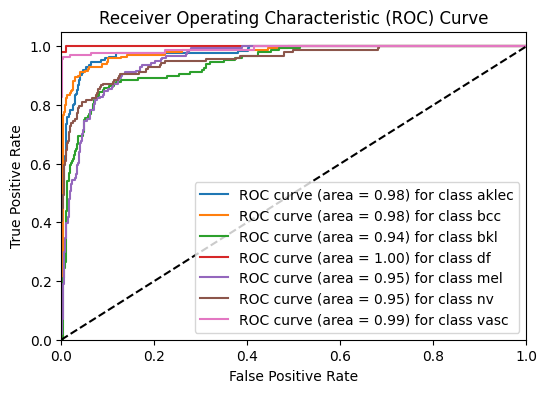

In [65]:
num_classes = 7

# Compute ROC curve and ROC area for each class
fpr_inception_resnet_v2 = dict()
tpr_inception_resnet_v2 = dict()
roc_auc_inception_resnet_v2 = dict()

# Assuming pred_xception contains probabilities and not one-hot encoded labels
for i in range(num_classes):
    fpr_inception_resnet_v2[i], tpr_inception_resnet_v2[i], _ = roc_curve((y_test == i).astype(int), pred_inception_resnet_v2[:, i])
    roc_auc_inception_resnet_v2[i] = auc(fpr_inception_resnet_v2[i], tpr_inception_resnet_v2[i])

# Plot ROC curve
plt.figure(figsize=(6, 4))

# Plot each class for inception_resnet_v2
for i in range(num_classes):
    plt.plot(fpr_inception_resnet_v2[i], tpr_inception_resnet_v2[i], label=f'ROC curve (area = {roc_auc_inception_resnet_v2[i]:0.2f}) for class {classes[i]}')

plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

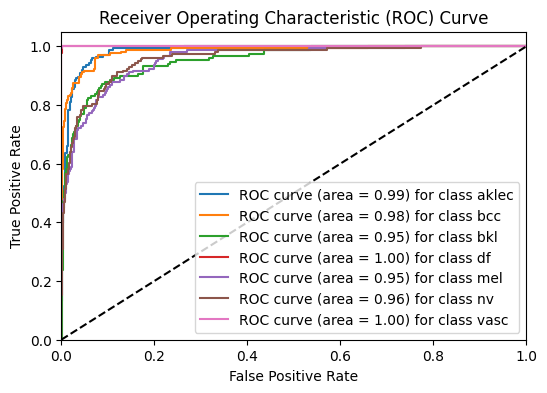

In [66]:
num_classes = 7

# Compute ROC curve and ROC area for each class
fpr_mobilenet_v2 = dict()
tpr_mobilenet_v2 = dict()
roc_auc_mobilenet_v2 = dict()

# Assuming pred_mobilenet contains probabilities and not one-hot encoded labels
for i in range(num_classes):
    fpr_mobilenet_v2[i], tpr_mobilenet_v2[i], _ = roc_curve((y_test == i).astype(int), pred_mobilenet_v2[:, i])
    roc_auc_mobilenet_v2[i] = auc(fpr_mobilenet_v2[i], tpr_mobilenet_v2[i])

# Plot ROC curve
plt.figure(figsize=(6, 4))

# Plot each class for mobilenet
for i in range(num_classes):
    plt.plot(fpr_mobilenet_v2[i], tpr_mobilenet_v2[i], label=f'ROC curve (area = {roc_auc_mobilenet_v2[i]:0.2f}) for class {classes[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [67]:
def show_plots(history):
  plt.subplots(figsize=(6,4))
  plt.plot(history.epoch, history.history["loss"], color="green", label="Train Loss")
  plt.plot(history.epoch, history.history["val_loss"], color="blue",
  label="Validation Loss")
  plt.xlabel("Epoch Number")
  plt.ylabel("Loss")
  plt.legend()
  plt.title("Loss Graph")
  plt.show()
  plt.subplots(figsize=(6,4))
  plt.plot(history.epoch, history.history["accuracy"], color="green",
  label="Train Accuracy")
  plt.plot(history.epoch, history.history["val_accuracy"], color="blue",
  label="Validation Accuracy")
  plt.xlabel("Epoch Number")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.title("Accuracy Graph")
  plt.show()

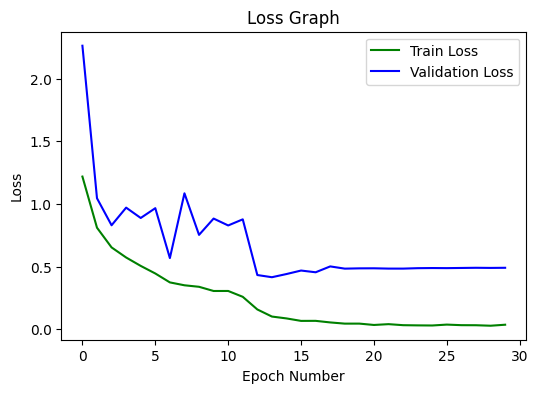

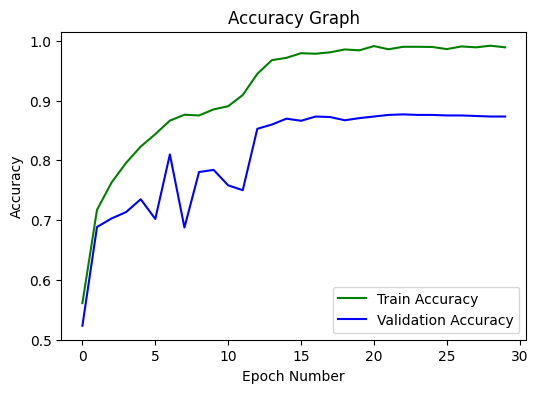

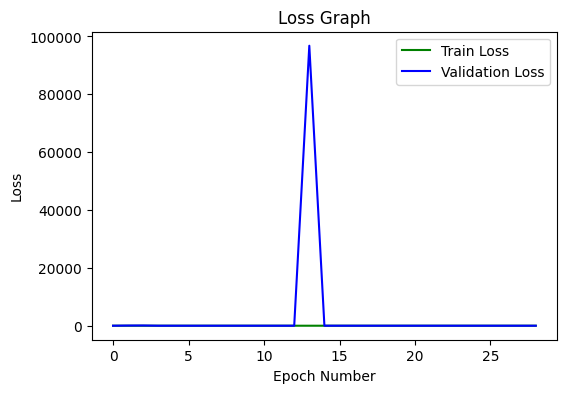

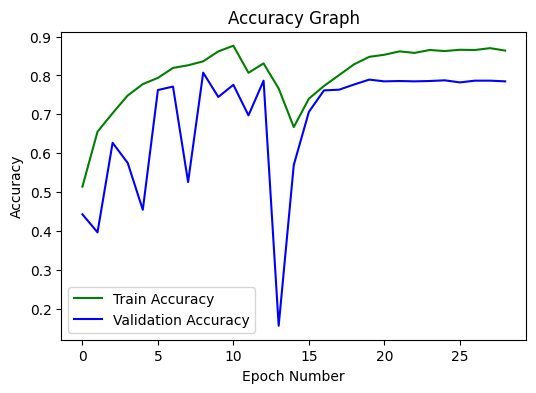

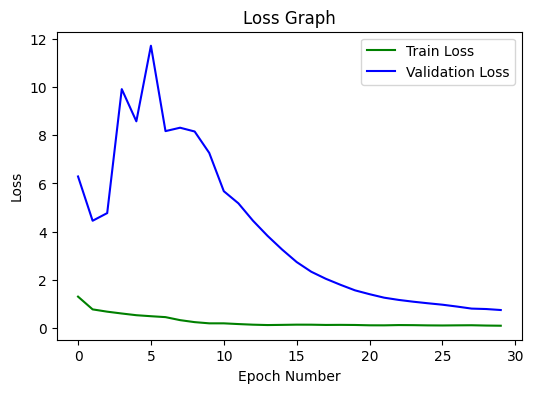

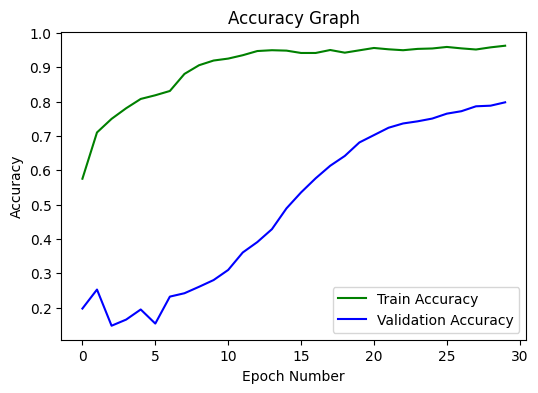

In [68]:
show_plots(history_xception)
show_plots(history_inception_resnet_v2)
show_plots(history_mobilenet_v2)